In [6]:

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session
sys.path.append('../input/yolov7-lib/yolov7-main')
import cv2
import kerastuner as kt
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
import torch
from torchvision import transforms
from utils.datasets import letterbox
from utils.general import non_max_suppression_kpt
from utils.plots import output_to_keypoint,plot_skeleton_kpts
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from IPython.display import HTML
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv1D, MaxPooling1D, Flatten, LSTM
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import json
import sys
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/tmp/ipykernel_33/4125905493.py:5: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  import kerastuner as kt


/kaggle/input/yolov7-lib/yolov7-main/train.py
/kaggle/input/yolov7-lib/yolov7-main/LICENSE.md
/kaggle/input/yolov7-lib/yolov7-main/hubconf.py
/kaggle/input/yolov7-lib/yolov7-main/.gitignore
/kaggle/input/yolov7-lib/yolov7-main/test.py
/kaggle/input/yolov7-lib/yolov7-main/README.md
/kaggle/input/yolov7-lib/yolov7-main/export.py
/kaggle/input/yolov7-lib/yolov7-main/train_aux.py
/kaggle/input/yolov7-lib/yolov7-main/requirements.txt
/kaggle/input/yolov7-lib/yolov7-main/detect.py
/kaggle/input/yolov7-lib/yolov7-main/utils/plots.py
/kaggle/input/yolov7-lib/yolov7-main/utils/metrics.py
/kaggle/input/yolov7-lib/yolov7-main/utils/autoanchor.py
/kaggle/input/yolov7-lib/yolov7-main/utils/google_utils.py
/kaggle/input/yolov7-lib/yolov7-main/utils/add_nms.py
/kaggle/input/yolov7-lib/yolov7-main/utils/loss.py
/kaggle/input/yolov7-lib/yolov7-main/utils/activations.py
/kaggle/input/yolov7-lib/yolov7-main/utils/datasets.py
/kaggle/input/yolov7-lib/yolov7-main/utils/__init__.py
/kaggle/input/yolov7-lib/

In [4]:
# Model and device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_path = "/kaggle/input/yolov7-weights/yolov7-w6-pose.pt"
weights = torch.load(model_path, map_location=device)
model = weights['model']
model.float().eval().to(device)

# Keypoint detection function
def get_keypoints(frame):
    img = letterbox(frame, 256, stride=64, auto=True)[0]
    img = transforms.ToTensor()(img).unsqueeze(0).to(device)
    with torch.no_grad():
        output, _ = model(img)
        output = non_max_suppression_kpt(output, 0.25, 0.65, nc=1, nkpt=17, kpt_label=True)
        keypoints = output_to_keypoint(output)
    return keypoints

# Extract keypoints from videos
def extract_keypoints_from_videos(video_paths):
    keypoints_list = []
    for video_path in video_paths:
        cap = cv2.VideoCapture(video_path)
        if not cap.isOpened():
            print(f"Error: Cannot open video {video_path}")
            continue
        while True:
            ret, frame = cap.read()
            if not ret:
                break
            keypoints = get_keypoints(frame)
            if keypoints.shape[0] > 0:
                keypoints_list.append(keypoints[0, 7:].flatten().tolist())
        cap.release()
    return keypoints_list

# Example data collection
normal_video_paths = ["/kaggle/input/kranoknv/Videos/Normal_00003.mp4"]
violent_video_paths = ["/kaggle/input/kranoknv/Videos/Violent_00416.mp4"]
normal_keypoints = extract_keypoints_from_videos(normal_video_paths)
violent_keypoints = extract_keypoints_from_videos(violent_video_paths)

# Combine data and labels
X = normal_keypoints + violent_keypoints
y = [0] * len(normal_keypoints) + [1] * len(violent_keypoints)
X = np.array(X)
y = np.array(y)


/opt/conda/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3526.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


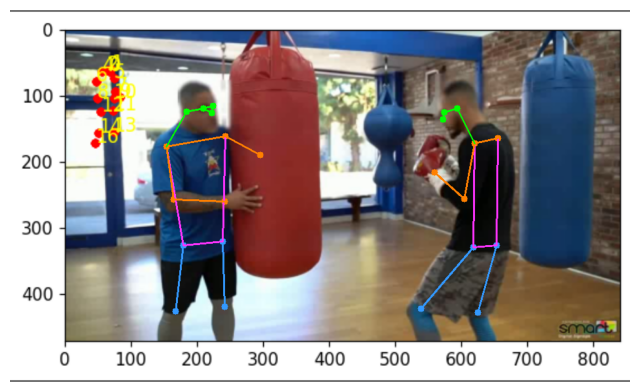

In [5]:
image_path = '/kaggle/input/indir/indir.png'
image = cv2.imread(image_path)
image = letterbox(image, 960, stride=64, auto=True)[0]
image_ = image.copy()
image = transforms.ToTensor()(image)
image = torch.tensor(np.array([image.numpy()]))

# Ensure the image and model weights are of the same type
if torch.cuda.is_available():
    image = image.float().to(device)  # Use float instead of half

# Model inference
with torch.no_grad():
    output, _ = model(image)
    output = non_max_suppression_kpt(output, 0.25, 0.65, nc=model.yaml['nc'], nkpt=model.yaml['nkpt'], kpt_label=True)
    keypoints = output_to_keypoint(output)

# Convert the image back for visualization
nimg = image[0].permute(1, 2, 0) * 255
nimg = nimg.cpu().numpy().astype(np.uint8)
nimg = cv2.cvtColor(nimg, cv2.COLOR_RGB2BGR)

# Plot the keypoints
for idx in range(keypoints.shape[0]):
    plot_skeleton_kpts(nimg, keypoints[idx, 7:].T, 3)

# Display the image with keypoints
%matplotlib inline
plt.figure(figsize=(8, 8))
plt.axis('off')
plt.imshow(nimg)
plt.show()

# plotting skeleton

In [13]:
# Keypoint detection function
def get_keypoints(frame, original_shape):
    img = letterbox(frame, 960, stride=64, auto=True)[0]
    img = transforms.ToTensor()(img).unsqueeze(0).to(device)
    with torch.no_grad():
        output, _ = model(img)
        output = non_max_suppression_kpt(output, 0.25, 0.65, nc=model.yaml['nc'], nkpt=model.yaml['nkpt'], kpt_label=True)
        keypoints = output_to_keypoint(output)
    if keypoints.shape[0] > 0:
        keypoints[:, 7:] = rescale_keypoints(keypoints[:, 7:], img.shape[2:], original_shape)
    return keypoints

def rescale_keypoints(keypoints, original_shape, new_shape):
    ratio_x = new_shape[1] / original_shape[1]
    ratio_y = new_shape[0] / original_shape[0]
    keypoints[:, ::3] *= ratio_x
    keypoints[:, 1::3] *= ratio_y
    return keypoints

# Process video and save output to a file
def process_video(video_path, output_path):
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print(f"Error: Cannot open video {video_path}")
        return

    # Get video properties
    fps = int(cap.get(cv2.CAP_PROP_FPS))
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    original_shape = (height, width)

    # Define the codec and create a VideoWriter object
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        keypoints = get_keypoints(frame, original_shape)
        if keypoints.shape[0] > 0:
            for idx in range(keypoints.shape[0]):
                plot_skeleton_kpts(frame, keypoints[idx, 7:].T, 3)

        out.write(frame)

    cap.release()
    out.release()

# Example usage
video_path = "/kaggle/input/kranoknv/Videos/Violent_00400.mp4"
output_path = "/kaggle/working/output_video.mp4"
process_video(video_path, output_path)

# Display the output video
from IPython.display import HTML

HTML("""
<video width="960" height="540" controls>
  <source src="/mnt/data/output_video.mp4" type="video/mp4">
  Your browser does not support the video tag.
</video>
""")

# collecting 2000 videos keypoints

In [14]:
# Model and device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_path = "/kaggle/input/yolov7-weights/yolov7-w6-pose.pt"
weights = torch.load(model_path, map_location=device)
model = weights['model']
model.float().eval().to(device)

# Keypoint detection function
def get_keypoints(frame, original_shape):
    img = letterbox(frame, 640, stride=64, auto=True)[0]
    img = transforms.ToTensor()(img).unsqueeze(0).to(device)
    with torch.no_grad():
        output, _ = model(img)
        output = non_max_suppression_kpt(output, 0.25, 0.65, nc=model.yaml['nc'], nkpt=model.yaml['nkpt'], kpt_label=True)
        keypoints = output_to_keypoint(output)
    if keypoints.shape[0] > 0:
        keypoints[:, 7:] = rescale_keypoints(keypoints[:, 7:], img.shape[2:], original_shape)
    return keypoints

def rescale_keypoints(keypoints, original_shape, new_shape):
    ratio_x = new_shape[1] / original_shape[1]
    ratio_y = new_shape[0] / original_shape[0]
    keypoints[:, ::3] *= ratio_x
    keypoints[:, 1::3] *= ratio_y
    return keypoints

# Function to extract keypoints from a list of video paths
def extract_keypoints_from_videos(video_paths, label):
    keypoints_list = []
    labels = []
    for video_path in video_paths:
        cap = cv2.VideoCapture(video_path)
        if not cap.isOpened():
            print(f"Error: Cannot open video {video_path}")
            continue
        while cap.isOpened():
            ret, frame = cap.read()
            if not ret:
                break
            original_shape = frame.shape[:2]
            keypoints = get_keypoints(frame, original_shape)
            if keypoints.shape[0] > 0:
                keypoints_list.append(keypoints[0, 7:].flatten().tolist())
                labels.append(label)
        cap.release()
    return keypoints_list, labels

# Example video paths
#normal_video_paths = ["/kaggle/input/kranoknv/Videos/Normal_00003.mp4",
#                     ""]
#violent_video_paths = ["/kaggle/input/kranoknv/Videos/Violent_00416.mp4"]
normal_videos = annotations_df[annotations_df['behavior'] == 'Normal'].sample(1000, random_state=42)
violent_videos = annotations_df[annotations_df['behavior'] == 'Violent'].sample(1000, random_state=42)

# Videoların yollarını oluşturma (mp4 uzantılı)
base_path = "/kaggle/input/kranoknv/Videos/"
normal_video_paths = [base_path + video.replace(".json", ".mp4") for video in normal_videos['video'].unique()]
violent_video_paths = [base_path + video.replace(".json", ".mp4") for video in violent_videos['video'].unique()]


# Extract keypoints from normal and violent videos
normal_keypoints, normal_labels = extract_keypoints_from_videos(normal_video_paths, 0)
violent_keypoints, violent_labels = extract_keypoints_from_videos(violent_video_paths, 1)

# Combine keypoints and labels
X = normal_keypoints + violent_keypoints
y = normal_labels + violent_labels

# Convert to numpy arrays
X = np.array(X)
y = np.array(y)
X_df = pd.DataFrame(X)
y_df = pd.DataFrame(y, columns=['label'])

# Save DataFrames to CSV files
X_df.to_csv("X.csv", index=False)
y_df.to_csv("y.csv", index=False)

In [7]:
X = pd.read_csv("/kaggle/input/datas/X.csv")
y = pd.read_csv("/kaggle/input/datas/y.csv")

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# y_train ve y_test'i 1 boyutlu hale getirme
y_train = y_train.values.ravel()
y_test = y_test.values.ravel()

X_train_rnn = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test_rnn = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))


In [ ]:
# Verileri yükleme ve hazırlama
X = pd.read_csv("/kaggle/input/datas/X.csv")
y = pd.read_csv("/kaggle/input/datas/y.csv")

# Veriyi bölme ve ölçeklendirme
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# y_train ve y_test'i 1 boyutlu hale getirme
y_train = y_train.values.ravel()
y_test = y_test.values.ravel()

# Verileri LSTM girişine uygun şekle getirme
X_train_rnn = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test_rnn = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

In [8]:
# LSTM Modeli oluşturma
model_rnn = Sequential()
model_rnn.add(LSTM(50, activation='relu', input_shape=(X_train.shape[1], 1)))
model_rnn.add(Dense(2, activation='softmax'))
model_rnn.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Etiketleri kategorik hale getirme
y_train_categorical = to_categorical(y_train, num_classes=2)

# LSTM modelini eğitme
model_rnn.fit(X_train_rnn, y_train_categorical, epochs=10, batch_size=32, validation_split=0.2)


/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
8429/8429 ━━━━━━━━━━━━━━━━━━━━ 150s 18ms/step - accuracy: 0.8973 - loss: 0.3805 - val_accuracy: 0.9393 - val_loss: 0.2170
Epoch 2/10
8429/8429 ━━━━━━━━━━━━━━━━━━━━ 150s 18ms/step - accuracy: 0.9409 - loss: 0.2125 - val_accuracy: 0.9419 - val_loss: 0.2039
Epoch 3/10
8429/8429 ━━━━━━━━━━━━━━━━━━━━ 201s 18ms/step - accuracy: 0.9429 - loss: 0.2228 - val_accuracy: 0.9435 - val_loss: 0.1994
Epoch 4/10
8429/8429 ━━━━━━━━━━━━━━━━━━━━ 151s 18ms/step - accuracy: 0.9440 - loss: 0.1964 - val_accuracy: 0.9439 - val_loss: 0.1955
Epoch 5/10
8429/8429 ━━━━━━━━━━━━━━━━━━━━ 152s 18ms/step - accuracy: 0.9451 - loss: 0.1893 - val_accuracy: 0.9442 - val_loss: 0.1865
Epoch 6/10
8429/8429 ━━━━━━━━━━━━━━━━━━━━ 148s 18ms/step - accuracy: 0.9458 - loss: 0.1810 - val_accuracy: 0.9456 - val_loss: 0.1793
Epoch 7/10
8429/8429 ━━━━━━━━━━━━━━━━━━━━ 147s 17ms/step - accuracy: 0.9451 - loss: 0.1776 - val_accuracy: 0.9455 - val_loss: 0.1795
Epoch 8/10
8429/8429 ━━━━━━━━━━━━━━━━━━━━ 152s 18ms/step - accuracy: 

In [20]:
predictions = model_rnn.predict(X_test_rnn)
predictions = np.argmax(predictions, axis=1)

# Performans metriklerini hesapla
accuracy = accuracy_score(y_test, predictions)
precision = precision_score(y_test, predictions)
recall = recall_score(y_test, predictions)
f1 = f1_score(y_test, predictions)

# Performans sonuçlarını yazdır
print("LSTM Model Performance on Test Set")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

2634/2634 ━━━━━━━━━━━━━━━━━━━━ 18s 7ms/step
LSTM Model Performance on Test Set
Accuracy: 0.9469
Precision: 0.9400
Recall: 0.9814
F1 Score: 0.9602


In [ ]:
# Model oluşturma fonksiyonu
def build_model(hp):
    model = Sequential()
    model.add(LSTM(units=hp.Int('units', min_value=32, max_value=512, step=32),
                   activation='relu',
                   input_shape=(X_train_rnn.shape[1], X_train_rnn.shape[2])))
    model.add(Dropout(rate=hp.Float('dropout', min_value=0.1, max_value=0.5, step=0.1)))
    model.add(Dense(2, activation='softmax'))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Keras Tuner ile hiperparametre optimizasyonu
tuner = kt.Hyperband(build_model,
                     objective='val_accuracy',
                     max_epochs=10,
                     factor=3,
                     directory='my_dir',
                     project_name='lstm_optimization')

# Etiketleri kategorik hale getirme
y_train_categorical = to_categorical(y_train, num_classes=2)
y_test_categorical = to_categorical(y_test, num_classes=2)

# Arama işlemini başlatma
tuner.search(X_train_rnn, y_train_categorical, epochs=10, validation_split=0.2)

# En iyi modeli al
best_model = tuner.get_best_models(num_models=1)[0]

# En iyi modeli değerlendirme
score = best_model.evaluate(X_test_rnn, y_test_categorical, verbose=0)
print(f'Test loss: {score[0]} / Test accuracy: {score[1]}')

Trial 8 Complete [00h 05m 59s]
val_accuracy: 0.9284718632698059

Best val_accuracy So Far: 0.9411223530769348
Total elapsed time: 03h 26m 53s

Search: Running Trial #9

Value             |Best Value So Far |Hyperparameter
352               |192               |units
0.5               |0.1               |dropout
2                 |2                 |tuner/epochs
0                 |0                 |tuner/initial_epoch
2                 |2                 |tuner/bracket
0                 |0                 |tuner/round

Epoch 1/2
7903/8429 ━━━━━━━━━━━━━━━━━━━━ 1:10 134ms/step - accuracy: 0.8191 - loss: 13.0297

# predicting on video

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_path = "/kaggle/input/yolov7-weights/yolov7-w6-pose.pt"
weights = torch.load(model_path, map_location=device)
model = weights['model']
model.float().eval().to(device)

# Keypoint detection function
def get_keypoints(frame, original_shape):
    img = letterbox(frame, 640, stride=64, auto=True)[0]
    img = transforms.ToTensor()(img).unsqueeze(0).to(device)
    with torch.no_grad():
        output, _ = model(img)
        output = non_max_suppression_kpt(output, 0.25, 0.65, nc=model.yaml['nc'], nkpt=model.yaml['nkpt'], kpt_label=True)
        keypoints = output_to_keypoint(output)
    if keypoints.shape[0] > 0:
        keypoints[:, 7:] = rescale_keypoints(keypoints[:, 7:], img.shape[2:], original_shape)
    return keypoints

def rescale_keypoints(keypoints, original_shape, new_shape):
    ratio_x = new_shape[1] / original_shape[1]
    ratio_y = new_shape[0] / original_shape[0]
    keypoints[:, ::3] *= ratio_x
    keypoints[:, 1::3] *= ratio_y
    return keypoints
def get_bounding_box_from_keypoints(keypoints):
    x_coords = keypoints[:, 0]
    y_coords = keypoints[:, 1]
    x_min = int(np.min(x_coords))
    y_min = int(np.min(y_coords))
    x_max = int(np.max(x_coords))
    y_max = int(np.max(y_coords))
    return x_min, y_min, x_max, y_max

def classify_keypoints(keypoints, model):
    keypoints = keypoints.cpu().numpy()
    keypoints = keypoints.reshape(-1, keypoints.shape[1], 1)
    prediction = model.predict(keypoints)
    return 'violent' if np.argmax(prediction[0]) == 1 else 'normal'

def process_video_with_classification(video_path, output_path, model):
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print(f"Error: Cannot open video {video_path}")
        return

    fps = int(cap.get(cv2.CAP_PROP_FPS))
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    original_shape = (height, width)

    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        keypoints = get_keypoints(frame, original_shape)
        if keypoints.shape[0] > 0:
            keypoints_flat = keypoints[0, 7:].flatten().tolist()
            keypoints_flat = torch.tensor(keypoints_flat, dtype=torch.float32).unsqueeze(0)
            classification = classify_keypoints(keypoints_flat, model)
            
            for idx in range(keypoints.shape[0]):
                plot_skeleton_kpts(frame, keypoints[idx, 7:].T, 3)
                
                x_min, y_min, x_max, y_max = get_bounding_box_from_keypoints(keypoints[idx, 7:].reshape(-1, 3))
                color = (0, 255, 0) if classification == 'normal' else (0, 0, 255)
                cv2.rectangle(frame, (x_min, y_min), (x_max, y_max), color, 2)
                cv2.putText(frame, classification, (x_min, y_min - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, color, 2, cv2.LINE_AA)

        out.write(frame)

    cap.release()
    out.release()



In [13]:
video_path = "/kaggle/input/violent/Warning graphic video_ Violent prison brawl caught on tape.mp4"
output_path = "/kaggle/working/output_video_classified_lstm.mp4"

process_video_with_classification(video_path, output_path, model_rnn)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━

In [12]:
video_path = "/kaggle/input/violent/Video Shows Bloody Fight in Subway Station in Harlem.mp4"
output_path = "/kaggle/working/output_video_classified_lstm_violent.mp4"
process_video_with_classification(video_path, output_path, model_rnn)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━

In [19]:
model_save_path = "/kaggle/working/model_rnn.h5"
model_rnn.save(model_save_path)